
Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [x] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [x] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

# Using Waterpumps Dataset (Aren't Ready w/ Own - Working Over Weekend)

I'm not planning on going into extreme detail, as to get back to my dataset ASAP.

In [145]:
import pandas as pd

DATA_SRC = '../data/waterpumps/'
train = pd.read_csv(DATA_SRC + 'train_features.csv')
test = pd.read_csv(DATA_SRC + 'test_features.csv')
labels = pd.read_csv(DATA_SRC + 'train_labels.csv')

train = train.merge(labels, on = 'id')

train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


# Prepare Model

Again, I'm doing this very basic as to get back to my dataset which needs more work ASAP.

In [146]:
train.shape, test.shape

((59400, 41), (14358, 40))

In [147]:
# Train - Val - Test Split

from sklearn.model_selection import train_test_split

train, val = train_test_split(train, train_size = 0.6, random_state = 42)

train.shape, val.shape, test.shape

((35640, 41), (23760, 41), (14358, 40))

In [148]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal = True).to_notebook_iframe()

profile

In [149]:
target = 'status_group'
features = train.columns.drop([target])

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

In [150]:
# Imports

from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.pipeline import make_pipeline

gb = make_pipeline(
                         ce.OrdinalEncoder(),
                         SimpleImputer(strategy = 'mean'),
                         XGBClassifier(learning_rate = 0.5))

gb.fit(X_train, y_train);



In [151]:
print(f'Train Score: {gb.score(X_train, y_train)}')
print(f'Validation Score: {gb.score(X_val, y_val)}')

Train Score: 0.7938271604938272
Validation Score: 0.7703282828282828


In [152]:
model = gb.named_steps.xgbclassifier
encoder = gb.named_steps.ordinalencoder
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)

X_train_encoded = encoder.transform(X_train)
X_val_encoded = encoder.transform(X_val)

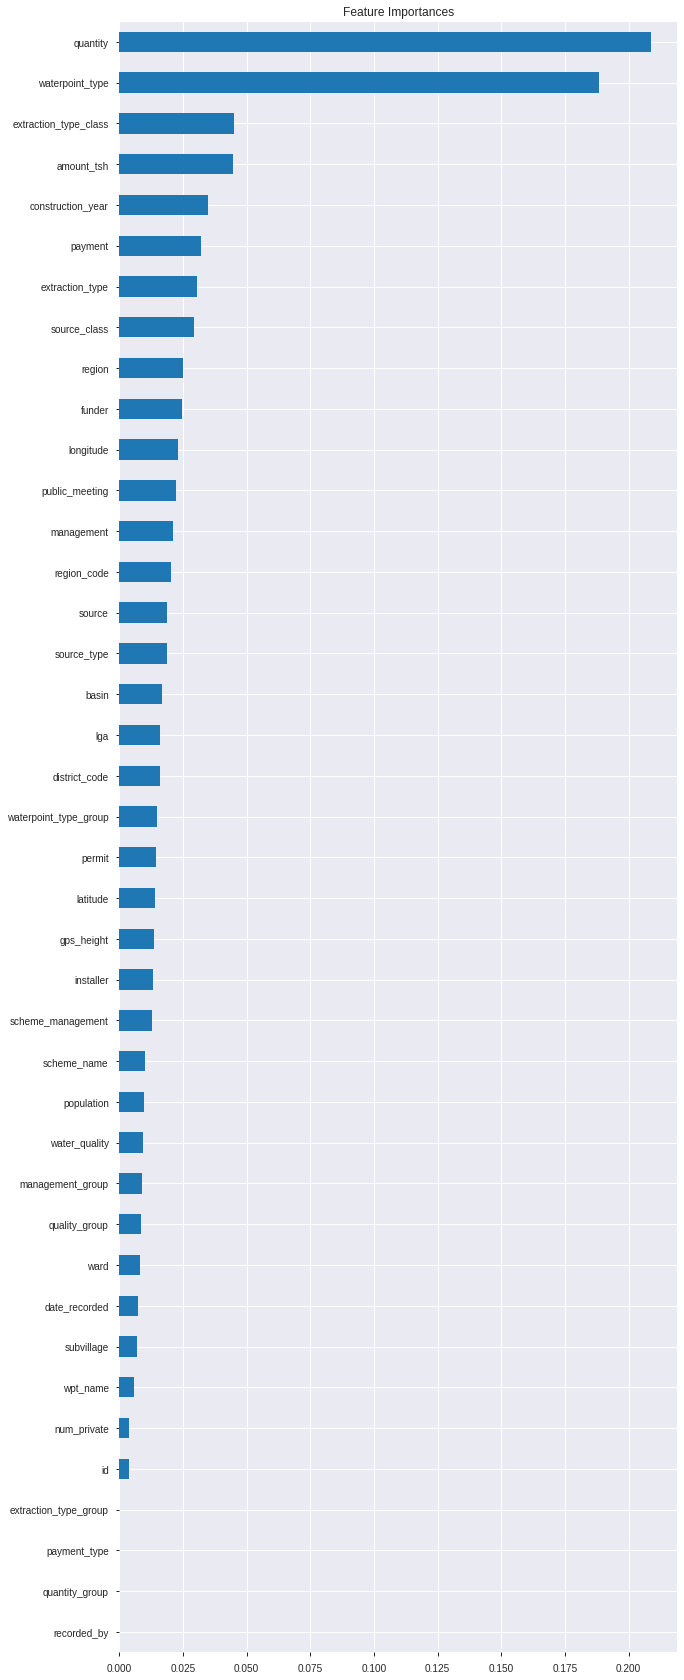

In [178]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 30))
plt.title('Feature Importances')

importances.sort_values().plot.barh();

# Partial Dependence Plot

In [154]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [155]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'gps_height'

isolated = pdp_isolate(
    model = gb,
    dataset = X_val,
    model_features = X_val.columns,
    feature = feature,
    num_grid_points = 25
)

quantity                 0.208694
waterpoint_type          0.188210
extraction_type_class    0.045110
amount_tsh               0.044693
construction_year        0.034745
dtype: float32

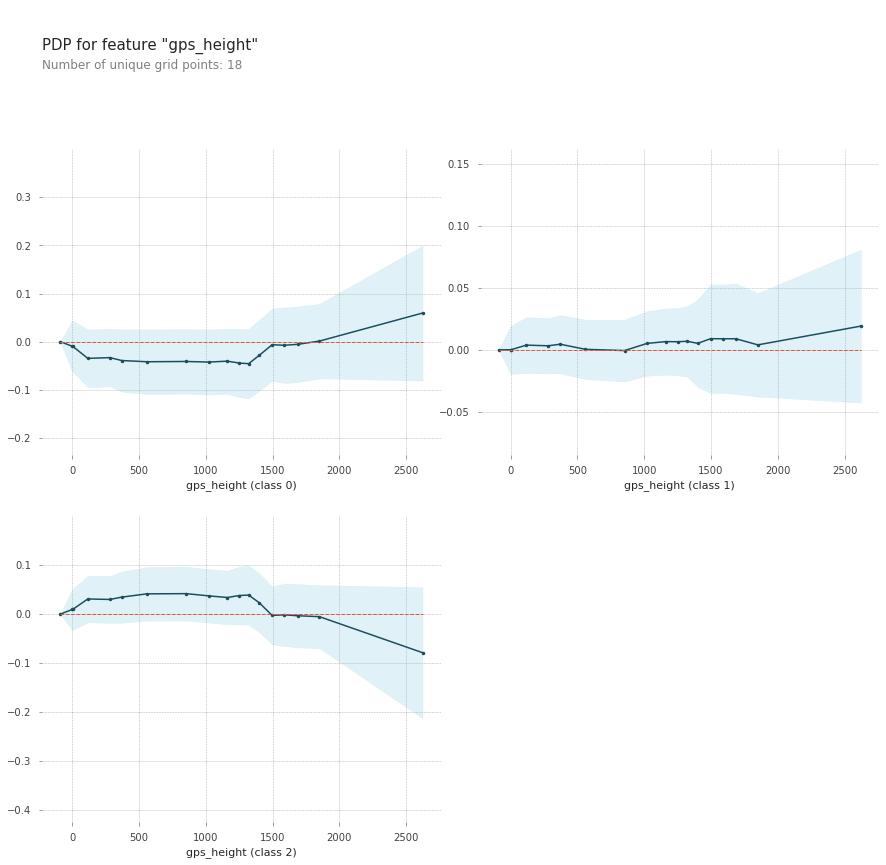

In [174]:
pdp_plot(isolated, feature_name = feature); # Non / Possibly / Is Functional

# Essentially, PDP is a way to know HOW what features influence the target >to what point<.


# Make a Shapely Force Plot

In [157]:
# Imports
import shap

In [183]:
row  = X_val_encoded.iloc[[0]] # Dataframe with a single row (double brackets keeps it a dataframe)


In [184]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

In [167]:
shap.initjs()

shap.force_plot(explainer.expected_value[0],
                shap_values = shap_values[0],
                features = row)

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'